## Instalação de pacotes

In [ ]:
!powershell pip install \
            face_recognition \
            git+https://github.com/ageitgey/face_recognition_models \
            opencv-python \
            pillow \
            numpy \
            tqdm \
            qdrant-client \
            setuptools \
            ipywidgets \
            matplotlib

## Rodar Qdrant

In [ ]:
!powershell docker run -p 6333:6333 -p 6334:6334 qdrant/qdrant

## Imports

In [1]:
import os
import uuid
import numpy as np
from tqdm import tqdm
import tkinter as tk
from tkinter import filedialog
import face_recognition
import face_recognition_models
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams, PointStruct
from qdrant_client import QdrantClient
from qdrant_client.models import Distance, VectorParams
from qdrant_client.models import Filter, SearchRequest
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## Configurações

In [2]:
def configura_ambiente(nome_colecao, tamanho_vetor):
    # Conectando ao Qdrant local
    client = QdrantClient("http://localhost:6333")

    # Cria a coleção se não existir
    if nome_colecao not in [c.name for c in client.get_collections().collections]:
        client.recreate_collection(
            collection_name=nome_colecao,
            vectors_config=VectorParams(size=tamanho_vetor, distance=Distance.COSINE),
        )
    
    return client

## Código para processar imagens do lfw_funneled e inserir na coleção

In [3]:
def processa_imagens(dir):
    '''
    Função usada para processar todos os diretórios e fotos dentro de lfw_funneled.

    Args:
        dir: Nome do diretório que contém as fotos.
    
    Returns:
        return: Vetor com as imagens processas em formato de PointStruct para serem inseridas na coleção.
    '''
    pontos = []
    diretorios = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d))]

    for pessoa in tqdm(diretorios, desc=f"Processando imagens..."):
        dir_pessoa = os.path.join(dir, pessoa)

        for nome_arq in os.listdir(dir_pessoa):
            if not nome_arq.endswith(".jpg"):
                continue

            caminho_imagem = os.path.join(dir_pessoa, nome_arq)
            imagem = face_recognition.load_image_file(caminho_imagem)
            embeddings = face_recognition.face_encodings(imagem)

            if len(embeddings) == 0:
                continue    # Pula se não encontrar rostos

            embedding_pessoa = embeddings[0]    # Presume que o primeiro e único rosto encontrado será da pessoa nomeada

            id_ponto = str(uuid.uuid4())    # ID único 

            # Cria estrutura de ponto para inserir na coleção
            pontos.append(
                PointStruct(
                    id=id_ponto,
                    vector=embedding_pessoa.tolist(),
                    payload={"nome": pessoa, "arquivo": caminho_imagem}
                )
            )
        
    return pontos

Código para processar apenas diretórios com mais de 3 imagens

In [11]:
def processa_imagens_reduzido(dir, num_min_fotos=5, num_max_fotos=7):
    '''
    Função usada para processar todos os diretórios e fotos dentro de lfw_funneled.

    Args:
        dir: Nome do diretório que contém as fotos.
        num_min_fotos: Número mínimo de fotos que o diretório deve conter para ser processado.
        num_max_fotos: Número máximo de fotos que o diretório deve conter para ser processado.

    Returns:
        return: Vetor com as imagens processas em formato de PointStruct para serem inseridas na coleção.
    '''
    pontos = []
    todos_diretorios = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d))]
    diretorios_selecionados = []
    for pessoa in todos_diretorios:
        dir_pessoa = os.path.join(dir, pessoa)
        if len(os.listdir(dir_pessoa)) >= num_min_fotos and len(os.listdir(dir_pessoa)) <= num_max_fotos:
            diretorios_selecionados.append(dir_pessoa)

    for pessoa in tqdm(diretorios_selecionados, desc=f"Processando imagens..."):
        for nome_arq in os.listdir(pessoa):
            if not nome_arq.endswith(".jpg"):
                continue

            caminho_imagem = os.path.join(pessoa, nome_arq)
            imagem = face_recognition.load_image_file(caminho_imagem)
            embeddings = face_recognition.face_encodings(imagem)

            if len(embeddings) == 0:
                continue    # Pula se não encontrar rostos

            embedding_pessoa = embeddings[0]    # Presume que o primeiro e único rosto encontrado será da pessoa nomeada

            id_ponto = str(uuid.uuid4())    # ID único 

            # Cria estrutura de ponto para inserir na coleção
            pontos.append(
                PointStruct(
                    id=id_ponto,
                    vector=embedding_pessoa.tolist(),
                    payload={"nome": pessoa.split('\\')[1], "arquivo": caminho_imagem}
                )
            )
        
    return pontos

## Códigos para o CRUD

In [ ]:
################ A SER IMPLEMENTADA ################
def inserir_imagem(client, nome_pessoa, filename):
    '''
    Função usada para processar e inserir uma imagem de uma pessoa na coleção.

    Args:
        filename: Caminho da imagem.
    
    Returns:
        return: 
    '''
    return

In [ ]:
################ A SER IMPLEMENTADA ################
def deletar_imagem(client, nome_pessoa):
    '''
    Função usada para deletar as fotos de uma pessoa na coleção.

    Args:
        nome_pessoa: Nome da pessoa a ser deletada.
    
    Returns:
        return: 
    '''
    return

## Códigos para processamento de imagens

In [7]:
def buscar_rostos_similares(client, colecao: str, arquivo: str, top_k: int = 5):
    '''
    Função usada para buscar os rostos mais similares à imagem passada como parâmetro.

    Args:
        colecao: Nome da coleção onde as imagens serão buscadas.
        arquivo: Caminho da imagem selecionada como parâmetro.
        top_k: Número de imagens semelhantes a serem retornadas.
    
    Returns:
        return: Vetor com as imagens mais semelhantes.
    '''

    imagem = face_recognition.load_image_file(arquivo)
    embedding = face_recognition.face_encodings(imagem)[0]
    resultado = client.search(collection_name=colecao, 
                              query_vector=embedding.tolist(), 
                              limit=top_k)
    
    return resultado

In [8]:
def exibir_resultados_similares(client, colecao: str, arquivo: str, top_k: int = 5):
    '''
    Exibe as imagens mais semelhantes à imagem fornecida, com nome da pessoa e scores de similaridade.

    Args:
        client: Cliente Qdrant.
        colecao: Nome da coleção onde as imagens serão buscadas.
        arquivo: Caminho da imagem selecionada como parâmetro.
        top_k: Número de imagens semelhantes a serem exibidas.
    '''

    resultados = buscar_rostos_similares(client, colecao, arquivo, top_k)

    # Carrega e exibe a imagem de entrada
    imagem_consulta = mpimg.imread(arquivo)
    plt.figure(figsize=(15, 4))
    plt.subplot(1, top_k + 1, 1)
    plt.imshow(imagem_consulta)
    plt.title("Imagem Consulta")
    plt.axis('off')

    # Exibe as imagens semelhantes
    for i, item in enumerate(resultados, start=2):
        caminho_imagem = item.payload.get("arquivo", "Desconhecido")
        nome_pessoa = item.payload.get("nome", "Desconhecido")
        score = item.score

        try:
            img = mpimg.imread(caminho_imagem)
        except FileNotFoundError:
            print(f"Arquivo não encontrado: {caminho_imagem}")
            continue

        plt.subplot(1, top_k + 1, i)
        plt.imshow(img)
        plt.title(f"{nome_pessoa}\nScore: {score:.2f}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

## Exemplo de uso

Configuração inicial

In [9]:
diretorio = "lfw_funneled"
nome_colecao = "lfw_faces"
tamanho_vetor = 128     # Número de dimensões do embedding do face_recognition

client = configura_ambiente(nome_colecao, tamanho_vetor)

In [12]:
# Processa imagens e insere no Qdrant
pontos = processa_imagens_reduzido(diretorio, num_min_fotos=5, num_max_fotos=7)
if pontos:
    client.upsert(collection_name=nome_colecao, points=pontos)
    print(f"Inseridos {len(pontos)} vetores na coleção '{nome_colecao}'")
else:
    print("Nenhuma imagem válida foi processada.")

Processando imagens...: 100%|██████████| 206/206 [08:22<00:00,  2.44s/it]


Inseridos 1158 vetores na coleção 'lfw_faces'


Teste de busca por similaridade

C:\Users\despinxz\AppData\Local\Temp\ipykernel_12912\2788007227.py:16: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  resultado = client.search(collection_name=colecao,


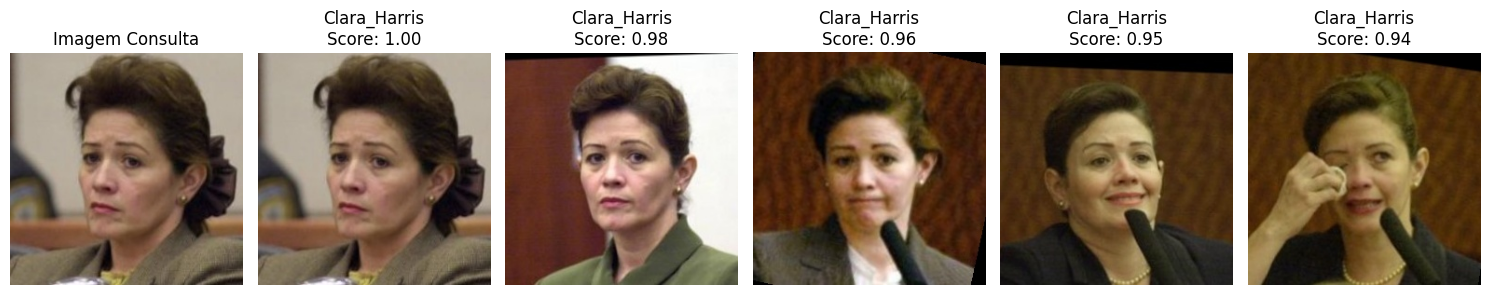

In [17]:
imagem_buscada = "lfw_funneled\\Clara_Harris\\Clara_Harris_0001.jpg"
exibir_resultados_similares(client, nome_colecao, imagem_buscada, 5)

## Comando para deletar coleção

In [ ]:
client.delete_collection(collection_name=nome_colecao)